# Network Science
## Final Project

### What happens with robustness in the presence of interdependent networks?

#### Ben Murphy 16-714-925
#### Florian Rüegsegger 16-714-737
#### Silvan Wehrli 15-703-275

## Introduction

We analyse the streetnetwork of Newyork/Manhattan in order to find where weakpoints of the system lie. In order to confirm our findings we define metrics by which we measure the speed at which cars can traverse through the network. 

- Randomly select two nodes and check how long it takes from Node A to B
- check average path length
- define metrics speed (Use edge attributes) (speedlimit, distance, time), (amount of nodes), (traffic?/real traffic data)
- simulate traffic
- compare to real traffic data
- randomly attack network in order to verify our choice of nodes
- try with other networks? Zurich?
- 


In [15]:
import networkx as nx
from networkx import read_graphml
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
import seaborn as sns
import osmnx as ox

LOAD = True

## Plotting functions

In [8]:
def plot_hist(data: List[float], title: str,label: str, xlabel: str = "", density=True, show=True):
    plt.hist(data, label=label, density=density)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f"{'density' if density else 'count'} ")
    if show:
        plt.legend()
        plt.show()
    

# General Data

In [16]:
def clean_data(graph, key_for_removal: str) -> nx.Graph:
    
    new_graph = nx.DiGraph()
    new_graph.graph = graph.graph
    for edge in graph.edges():
        start, end = edge
        keys = graph[start][end][key_for_removal].keys()
        data = {}
        for key in keys:
            if key in ["highway","name", "lanes","maxspeed","Bridge","Tunnel", "length"]:
                data[key] = graph[start][end][key_for_removal][key]
                if key == "length":
                    data[key] = float(data[key])
        new_graph.add_edge(start,end,**data)

    for node in graph.nodes().keys():
        for key in graph.nodes()[node].keys():
            if key in ["x", "y"]: 
                new_graph.nodes()[node][key] = float(graph.nodes()[node][key])
            elif key == "highway":
                new_graph.nodes()[node][key] = graph.nodes()[node][key]

                
    return new_graph    




In [17]:
if LOAD:
    print("Downloading data")
    graph = ox.graph_from_place('New York, USA', network_type='drive')
    print("adding the need for speed")
    graph = ox.speed.add_edge_speeds(graph)
    graph = ox.speed.add_edge_travel_times(graph, precision=1)
    print("Cleaning data")
    graph = clean_data(graph,0)
    print("write to file")
    nx.write_gml(graph,"data/osmnx_cleaned.gml")
graph = nx.read_gml("data/osmnx_cleaned.gml")

In [15]:
graph = nx.read_graphml("data/cleaned.graphml")

In [20]:
print(f"n nodes: {len(graph.nodes())}")
print(f"n edges: {len(graph.edges())}")
print(f"graph is directed: {nx.is_directed(graph)}")
print(f"graph weakly connected: {nx.is_weakly_connected(graph)}") # Treat edges as undirected
print(f"graph strongly connected: {nx.is_strongly_connected(graph)}") # Treat edges as directed

n nodes: 54128
n edges: 141673
graph is directed: True
graph weakly connected: True
graph strongly connected: False


### Component analysis

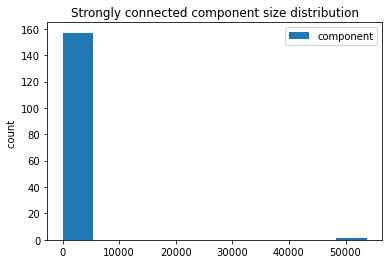

In [21]:
component_size = np.array([len(value) for index, value in enumerate(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))])
plot_hist(component_size, "Strongly connected component size distribution", "component", density=False)

We have a lot of small unconnected components (strong connectivity)

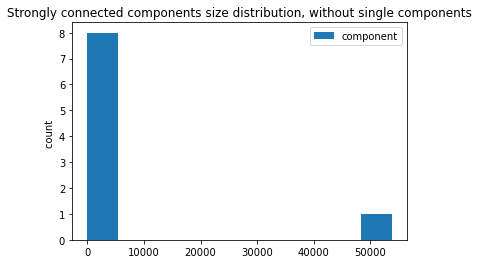

In [22]:
plot_hist(component_size[component_size>1], "Strongly connected components size distribution, without single components", "component", density=False)

By removing all components with size < 2 we end up with 9 components.  
Suggestion: Remove all components except the big one, since the small ones hardly matter

In [23]:
largest_component = list(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))[0]
graph = graph.subgraph(largest_component)

In [24]:

print(f"n nodes: {len(graph.nodes())}")
print(f"n edges: {len(graph.edges())}")
print(f"graph is directed: {nx.is_directed(graph)}")
print(f"graph weakly connected: {nx.is_weakly_connected(graph)}") # Treat edges as undirected
print(f"graph strongly connected: {nx.is_strongly_connected(graph)}") # Treat edges as directed

n nodes: 53769
n edges: 140877
graph is directed: True
graph weakly connected: True
graph strongly connected: True


### degree distribution

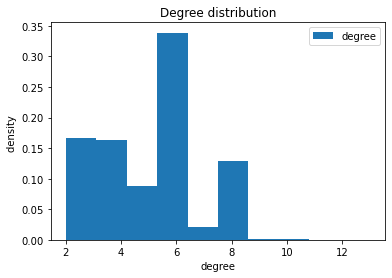

In [25]:
degrees = [i[1] for i in graph.degree()]
plot_hist(degrees, "Degree distribution", "degree", "degree")

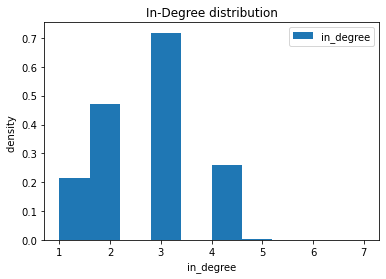

In [26]:
in_degrees = [i[1] for i in graph.in_degree()]
plot_hist(in_degrees, "In-Degree distribution", "in_degree", "in_degree")

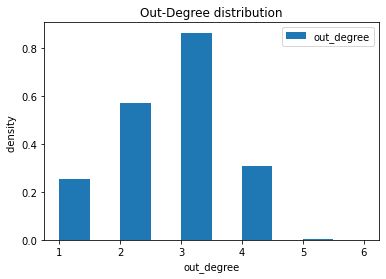

In [27]:

out_degrees = [i[1] for i in graph.out_degree()]
plot_hist(out_degrees, "Out-Degree distribution", "out_degree", "out_degree")

C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


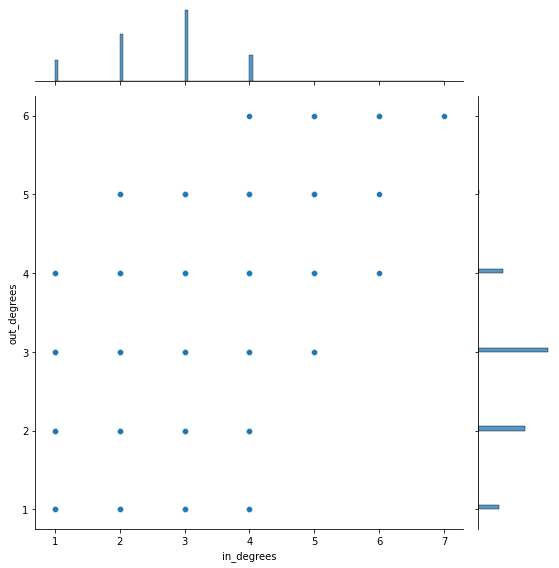

In [28]:
degrees = {
    "in_degrees":in_degrees,
    "out_degrees":out_degrees
}
sns.jointplot(x="in_degrees",y="out_degrees",data=degrees, size=8)


### Assortativity

In [29]:
rand_graph = nx.directed_configuration_model(dict(graph.in_degree()).values(), dict(graph.out_degree()).values(), seed=128)
print(f"graph degree assortativity: {nx.degree_assortativity_coefficient(graph)}")
print(f"Random graph degree assortativity: {nx.degree_assortativity_coefficient(rand_graph)}")


graph degree assortativity: 0.4490046686594745
Random graph degree assortativity: -0.0004408664167564861


In [30]:
print(f"graph density: {nx.density(graph)}")
print(f"rand graph density: {nx.density(rand_graph)}")

graph density: 4.8728635763481043e-05
rand graph density: 4.8728635763481043e-05


In [45]:
print(graph["43010059"]["42997670"])

{'name': "[u'Ayres Road', u'USS North Carolina Road']", 'length': 370.361794408, 'highway': 'residential'}


In [32]:
shortest = nx.shortest_path(graph,"43010059","42485784")
shortest_lenght = nx.shortest_path(graph,"43010059","42485784", weight="length")

print(shortest)
print(shortest_lenght)


['43010059', '42997670', '42973702', '43001626', '42967777', '43000273', '42972429', '42963994', '3788074254', '3788073410', '598367717', '411566447', '598365272', '448152999', '448151945', '598365343', '598357844', '598357866', '449588013', '449030764', '449030765', '449025477', '1369722069', '449388516', '449388143', '588152198', '1942054997', '588152221', '588152228', '588152150', '588152159', '588152360', '42497305', '1942053136', '42508608', '42508600', '42479945', '42508588', '42508585', '42486048', '42485782', '42485784']
['43010059', '42985240', '42963092', '42963041', '43001626', '42967777', '43000273', '42972429', '42997660', '42963994', '3788074254', '3788073410', '598367717', '411566447', '598365272', '448152999', '448151945', '598365343', '598357844', '598357851', '598357852', '42460776', '42461034', '42461032', '42461020', '42461018', '42461014', '42461010', '42461007', '42461003', '42460999', '42460996', '4026460352', '4026460338', '42460985', '42460984', '42460982', '42

In [32]:
# calculate weights
# include speed_limit, distance, (amount of lanes, (time of day/traffic)),
# calculate weight by looking at neighbouring nodes
# Time = distance / speed_limit
# Weight = (Time - min(Time)) / (max(time) - min(time)) # standardise to get values between (0,1)
# lower weight => less time => better route



In [46]:
graph["43010059"]["42997670"]

{'name': "[u'Ayres Road', u'USS North Carolina Road']",
 'length': 370.361794408,
 'highway': 'residential'}